In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Load data

In [2]:
ny_crime = pd.read_excel('crime_in_ny_state.xls', header=4, nrows=348)
ny_crime = ny_crime.rename(columns= {'City':'city', 'Population':'pop', 
                          'Violent\ncrime':'violent_crime', 
                          'Murder and\nnonnegligent\nmanslaughter': 'murder',
                          'Rape\n(revised\ndefinition)1': 'rape_new',
                          'Rape\n(legacy\ndefinition)2': 'rape_old', 
                          'Robbery': 'robbery', 
                          'Aggravated\nassault': 'assault', 
                          'Property\ncrime': 'property_crime', 
                          'Burglary': 'burglary', 
                          'Larceny-\ntheft': 'larceny', 
                          'Motor\nvehicle\ntheft':'vehicle_theft', 
                          'Arson3':'arson'})

## Explore data

In [3]:
ny_crime.head()

,city,pop,violent_crime,murder,rape_new,rape_old,robbery,assault,property_crime,burglary,larceny,vehicle_theft,arson
0,Adams Village,1861,0,0,NaN,0,0,0,12,2,10,0,0.0
1,Addison Town and Village,2577,3,0,NaN,0,0,3,24,3,20,1,0.0
2,Akron Village,2846,3,0,NaN,0,0,3,16,1,15,0,0.0
3,Albany,97956,791,8,NaN,30,227,526,4090,705,3243,142,NaN
4,Albion Village,6388,23,0,NaN,3,4,16,223,53,165,5,NaN


Note that violent crime is the sum of: murder, rape, robbery and assault.<br>
Note that property crime is the sum of: burglary, larceny, vehicle theft and arson.

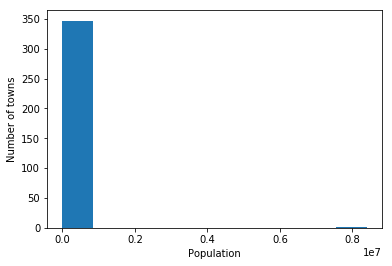

In [4]:
plt.hist(ny_crime['pop'])
plt.xlabel('Population')
plt.ylabel('Number of towns')
plt.show()

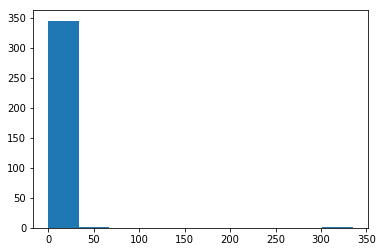

In [5]:
plt.hist(ny_crime.murder)
plt.show()

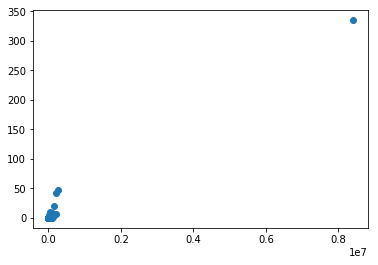

In [6]:
plt.scatter(x = ny_crime['pop'], y = ny_crime['murder'])
plt.show()

In [7]:
ny_crime.loc[ny_crime.murder > 300, ]

,city,pop,violent_crime,murder,rape_new,rape_old,robbery,assault,property_crime,burglary,larceny,vehicle_theft,arson
216,New York,8396126,52384,335,NaN,1112,19170,31767,141971,16606,117931,7434,NaN


The New York City point is such an outlier it will swamp the data and have a huge effect on any regression. I am going to drop this row for the analysis.

In [8]:
ny_crime_no_ny = ny_crime.loc[ny_crime.murder < 300, ]

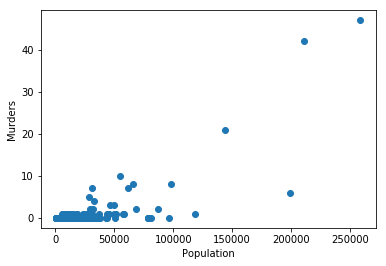

In [9]:
plt.scatter(ny_crime_no_ny['pop'], ny_crime_no_ny['murder'])
plt.xlabel('Population')
plt.ylabel('Murders')
plt.show()

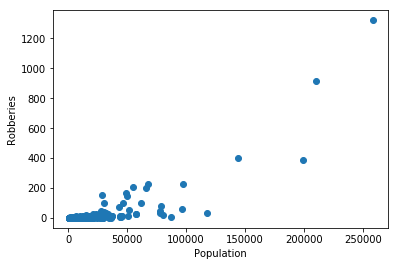

In [10]:
plt.scatter('pop', 'robbery', data=ny_crime_no_ny)
plt.xlabel('Population')
plt.ylabel('Robberies')
plt.show()

## Create potential features and check for linear relationship

In [11]:
potential_features = pd.DataFrame()
potential_features['prop_crime'] = ny_crime_no_ny['property_crime']
potential_features['pop'] = ny_crime_no_ny['pop']
potential_features['pop_sq'] = ny_crime_no_ny['pop']**2
potential_features['murder_cat'] = np.where(ny_crime_no_ny.murder >0, 1, 0)
potential_features['robbery_cat'] = np.where(ny_crime_no_ny.robbery > 0, 1, 0)

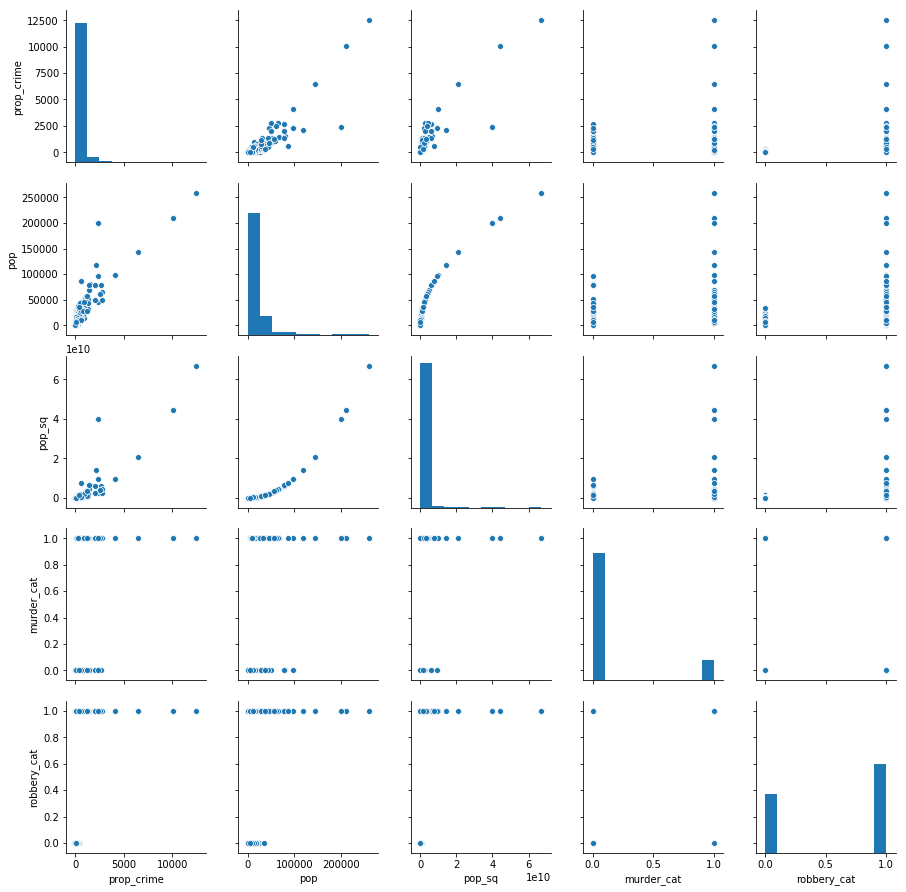

In [12]:
sns.pairplot(potential_features,
            diag_kind='hist')
plt.show()

Population looks more linear with the property crime outcome than population squared so I will discard population squared.

In [13]:
potential_features.drop('pop_sq', axis=1, inplace=True)

In [14]:
potential_features['rape'] = ny_crime_no_ny['rape_old']
potential_features['assault'] = ny_crime_no_ny['assault']

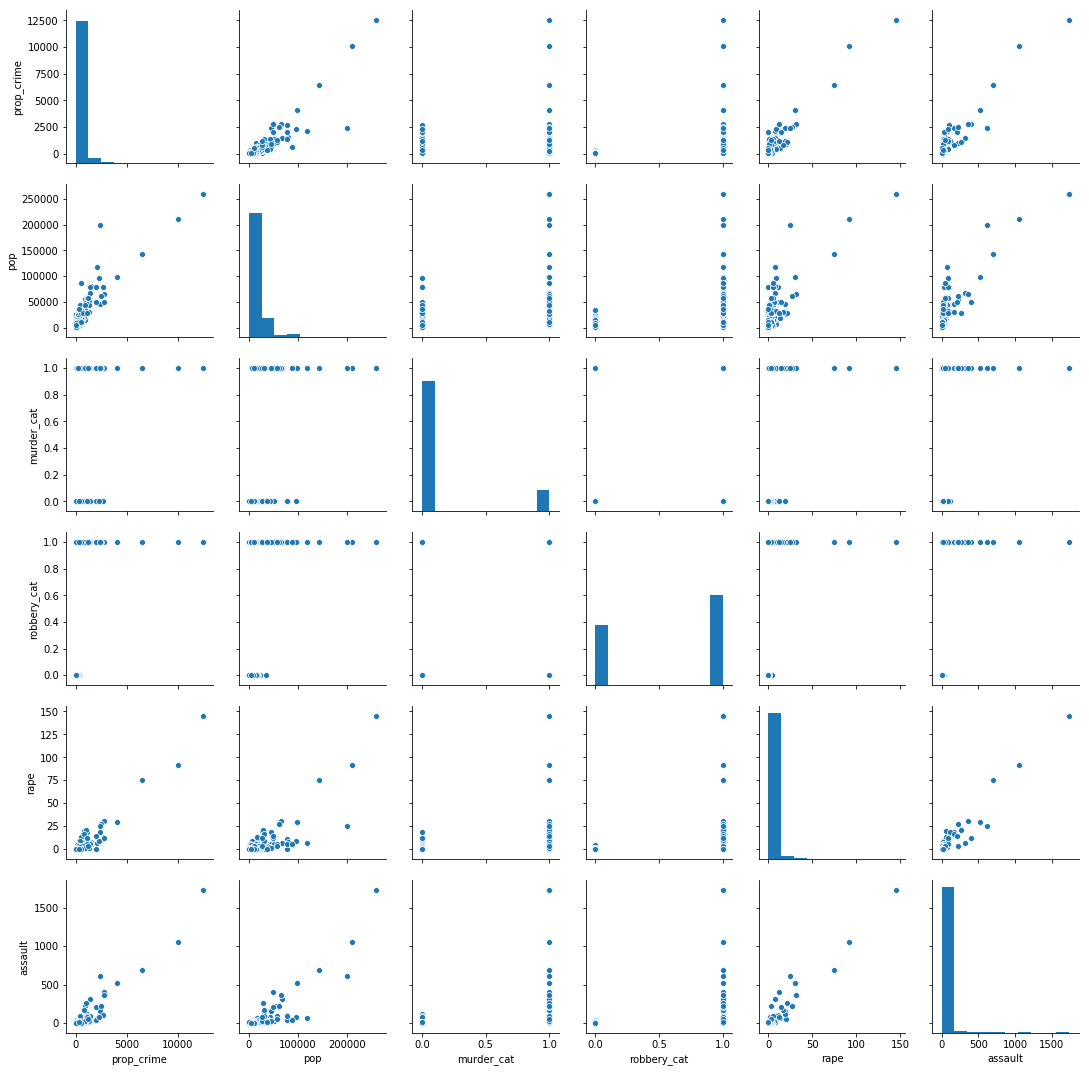

In [15]:
sns.pairplot(potential_features,
            diag_kind='hist')
plt.show()

These look quite linear. There is quite a lot of correlation between variables so it may be necessary to do some transformations later such as interactions or PCA. However, I will do an initial regression first.

## Linear model 1
### Create model

In [16]:
regr_1 = linear_model.LinearRegression()
Y_1 = potential_features['prop_crime'].values.reshape(-1, 1)
X_1 = potential_features[['murder_cat', 'robbery_cat', 'rape', 'assault', 'pop']]
regr_1.fit(X_1, Y_1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [17]:
print('Coefficients: ', regr_1.coef_)
print('Intercept: ', regr_1.intercept_)
print('R-squared: ', regr_1.score(X_1, Y_1))

Coefficients:  [[-3.23649964e+01  6.06601785e+01  5.48746805e+01  9.94645719e-01
   1.24321647e-02]]
Intercept:  [-21.32288886]
R-squared:  0.9489815953617193


### Check assumptions

The residuals should show a normal distribution.

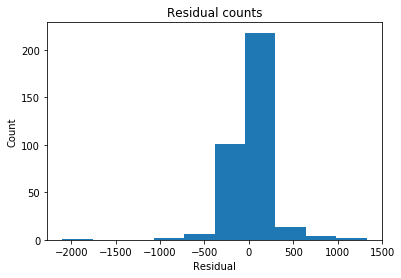

In [18]:
predicted_1 = regr_1.predict(X_1).ravel()
actual = potential_features['prop_crime']
residual_1 = actual - predicted_1

plt.hist(residual_1)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

This is not too bad. It is not particularly skewed and most errors are small.

The model should also be homoscedastic - i.e. the distribution of the error terms should be consistent.

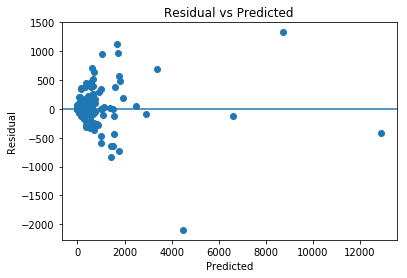

In [19]:
plt.scatter(predicted_1, residual_1)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs Predicted')
plt.show()

This looks as though there are still some outliers having a large influence on the regression. It is difficult to see the distribution at the lower end but it looks as though the variance increases as the outcome increases.

Check for multicollinearity.

In [20]:
corrmat_1 = X_1.corr()
display(corrmat_1)

,murder_cat,robbery_cat,rape,assault,pop
murder_cat,1.000000,0.310503,0.402744,0.421846,0.502713
robbery_cat,0.310503,1.000000,0.188700,0.175605,0.344347
rape,0.402744,0.188700,1.000000,0.958098,0.796629
assault,0.421846,0.175605,0.958098,1.000000,0.834682
pop,0.502713,0.344347,0.796629,0.834682,1.000000


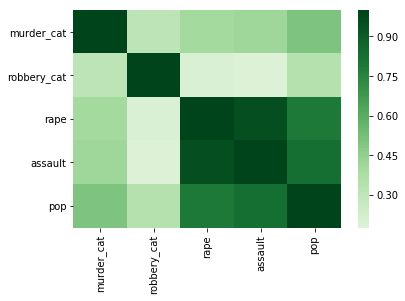

In [21]:
sns.heatmap(corrmat_1,
           cmap='PRGn', center=0)
plt.show()

Population, rape and assault are highly correlated so one or more should be dropped. I will test which gives the best outcome.

## Linear model 2 - drop pop and assault

In [22]:
regr_2 = linear_model.LinearRegression()
Y_2 = potential_features['prop_crime'].values.reshape(-1, 1)
X_2 = potential_features[['murder_cat', 'robbery_cat', 'rape']]
regr_2.fit(X_2, Y_2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [23]:
print('Coefficients: ', regr_2.coef_)
print('Intercept: ', regr_2.intercept_)
print('R-squared: ', regr_2.score(X_2, Y_2))

Coefficients:  [[153.29156234 165.47503603  87.9596753 ]]
Intercept:  [29.86933474]
R-squared:  0.9103158817754645


## Linear model 3 - drop pop and rape

In [24]:
regr_3 = linear_model.LinearRegression()
Y_3 = potential_features['prop_crime'].values.reshape(-1, 1)
X_3 = potential_features[['murder_cat', 'robbery_cat', 'assault']]
regr_3.fit(X_3, Y_3)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [25]:
print('Coefficients: ', regr_3.coef_)
print('Intercept: ', regr_3.intercept_)
print('R-squared: ', regr_3.score(X_3, Y_3))

Coefficients:  [[ 83.7239543  206.0556208    7.33289094]]
Intercept:  [30.20450372]
R-squared:  0.8984655801628051


## Linear model 4 - drop rape and assault

In [26]:
regr_4 = linear_model.LinearRegression()
Y_4 = potential_features['prop_crime'].values.reshape(-1, 1)
X_4 = potential_features[['murder_cat', 'robbery_cat', 'pop']]
regr_4.fit(X_4, Y_4)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [27]:
print('Coefficients: ', regr_4.coef_)
print('Intercept: ', regr_4.intercept_)
print('R-squared: ', regr_4.score(X_4, Y_4))

Coefficients:  [[ 1.43473775e+01 -9.42521334e+01  3.43860764e-02]]
Intercept:  [-108.42335404]
R-squared:  0.7889428000907828


So population alone is worse predictor than rape or assault alone.

## Assess linear model 2 for assumptions

### Residuals

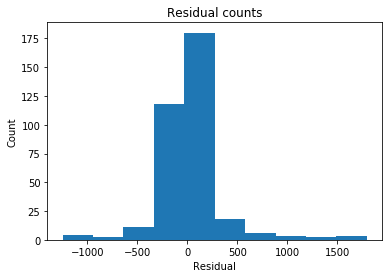

In [28]:
predicted_2 = regr_2.predict(X_2).ravel()
actual = potential_features['prop_crime']
residual_2 = actual - predicted_2

plt.hist(residual_2)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

These look fairly normal.

### Heteroscedasticity

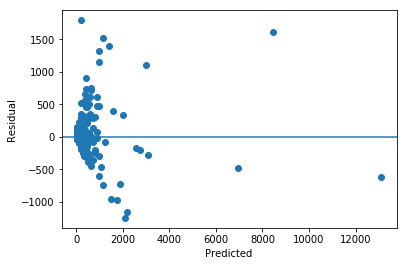

In [29]:
plt.scatter(predicted_2, residual_2)
plt.axhline(y=0)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.show()

The results still may be skewed by the outliers. Replot without the outliers so can see the shape better.

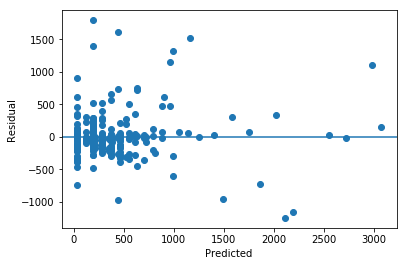

In [30]:
model_2 = pd.DataFrame()
model_2['predicted']= predicted_2
model_2['residual'] = residual_2
model_2 = model_2.sort_values('predicted')
model_2.reset_index(inplace=True)
model_2 = model_2.drop('index', axis=1)
model_2_miss3 = model_2.drop(model_2.index[344:], axis=0)

plt.scatter('predicted', 'residual', data=model_2_miss3)
plt.axhline(y=0)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.show()

This looks good - the points are fairly randomly spread. There may not even be an increase in variance as the predicted amount increases - the points are just sparser.

## More feature engineering - Transforming the dependent variable to make it normal

Idea from here: https://statswithcats.wordpress.com/2010/11/21/fifty-ways-to-fix-your-data/

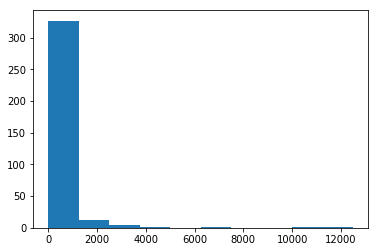

In [31]:
plt.hist(potential_features.prop_crime)
plt.show()

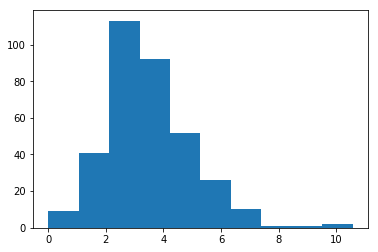

In [32]:
plt.hist(potential_features['prop_crime']**(0.25))
plt.show()

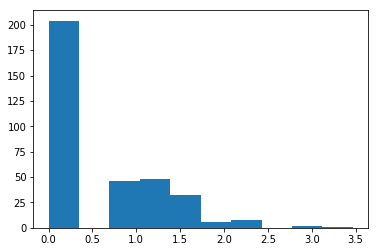

In [33]:
plt.hist(potential_features['rape']**(0.25))
plt.show()

In [34]:
potential_features_2 = pd.DataFrame()
potential_features_2['prop_crime_4rt'] = potential_features['prop_crime']**(0.25)
potential_features_2['murder_cat'] = potential_features['murder_cat']
potential_features_2['robbery_cat'] = potential_features['robbery_cat']
potential_features_2['rape_4rt'] = potential_features['rape']**(0.25)
potential_features_2['rape'] = potential_features['rape']
potential_features_2.head()

,prop_crime_4rt,murder_cat,robbery_cat,rape_4rt,rape
0,1.861210,0,0,0.000000,0
1,2.213364,0,0,0.000000,0
2,2.000000,0,0,0.000000,0
3,7.997069,1,1,2.340347,30
4,3.864348,0,1,1.316074,3


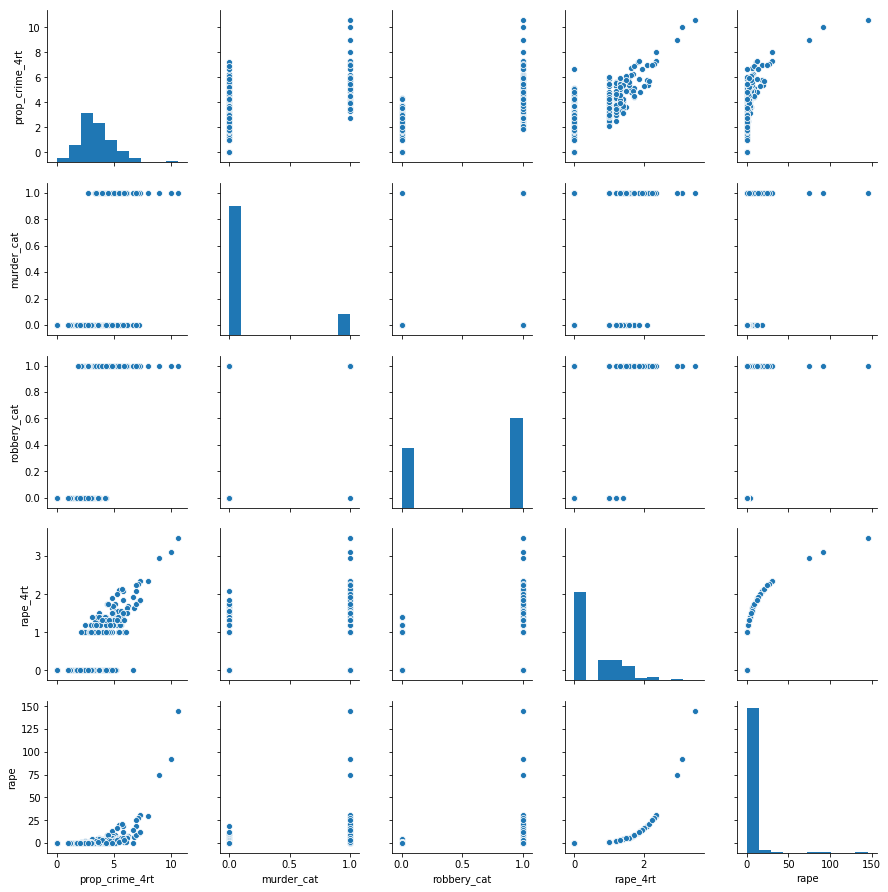

In [35]:
sns.pairplot(potential_features_2,
            diag_kind='hist')
plt.show()

## Linear model 5 - transformed dependent variable

In [36]:
regr_5 = linear_model.LinearRegression()
Y_5 = potential_features_2['prop_crime_4rt'].values.reshape(-1, 1)
X_5 = potential_features_2[['murder_cat', 'robbery_cat', 'rape_4rt']]
regr_5.fit(X_5, Y_5)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [37]:
print('Coefficients: ', regr_5.coef_)
print('Intercept: ', regr_5.intercept_)
print('R-squared: ', regr_5.score(X_5, Y_5))

Coefficients:  [[0.7221512  1.03669281 1.06919106]]
Intercept:  [2.17699276]
R-squared:  0.6914903075826508


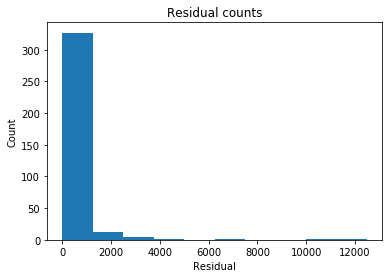

In [38]:
predicted_5 = regr_5.predict(X_5).ravel()
actual = potential_features['prop_crime']
residual_5 = actual - predicted_5

plt.hist(residual_5)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

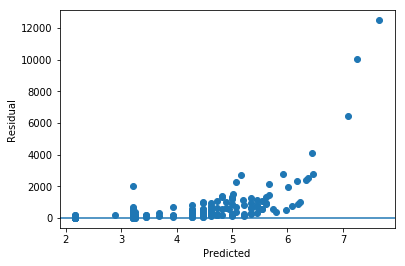

In [39]:
plt.scatter(predicted_5, residual_5)
plt.axhline(y=0)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.show()

These assumption graphs look worse than before. Discard this idea.

## More feature engineering - Try PCA on all variables

In [40]:
potential_features.head()

,prop_crime,pop,murder_cat,robbery_cat,rape,assault
0,12,1861,0,0,0,0
1,24,2577,0,0,0,3
2,16,2846,0,0,0,3
3,4090,97956,1,1,30,526
4,223,6388,0,1,3,16


In [41]:
potential_features_pca = potential_features[['pop', 'rape', 'assault']]

In [42]:
X = StandardScaler().fit_transform(potential_features_pca)

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [43]:
## Create correlation matrix

Xt = X.T
Cx = np.cov(Xt)
Cx

array([[1.00289017, 0.79893175, 0.83709394],
       [0.79893175, 1.00289017, 0.96086745],
       [0.83709394, 0.96086745, 1.00289017]])

In [44]:
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].reshape(1, 3).T
    print('Eignvector {}. \n{})'.format(i+1, eigvec_cov))
    print('Eigenvalue {}: {}'.format(i+1, eig_val_cov[i]))
    print(40*'-')

Eignvector 1. 
[[0.55521886]
 [0.58415812]
 [0.59202307]])
Eigenvalue 1: 2.7360470629593054
----------------------------------------
Eignvector 2. 
[[ 0.82567796]
 [-0.47267336]
 [-0.30795421]])
Eigenvalue 2: 0.2333160966993856
----------------------------------------
Eignvector 3. 
[[-0.09993958]
 [-0.65980239]
 [ 0.74476365]])
Eigenvalue 3: 0.03930736057252561
----------------------------------------


In [45]:
eig_vec_cov[:, 0]

array([0.55521886, 0.58415812, 0.59202307])

In [46]:
Y = eig_vec_cov[:, 0].T.dot(Xt)

In [47]:
sklearn_pca = PCA(n_components=1)
Y_sklearn = sklearn_pca.fit_transform(X)

Check manual PCA calculation same as sklearn:

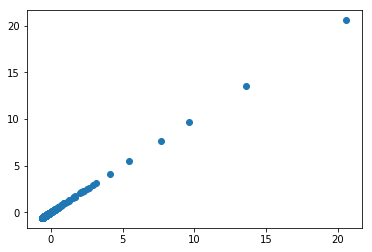

In [48]:
plt.scatter(Y, Y_sklearn)
plt.show()

Straight line so yes.

In [49]:
potential_features_6 = pd.DataFrame()
potential_features_6['prop_crime'] = potential_features['prop_crime']
potential_features_6['murder_cat'] = potential_features['murder_cat']
potential_features_6['robbery_cat'] = potential_features['robbery_cat']
potential_features_6['pra_pca'] = Y

In [50]:
potential_features_6.head()

,prop_crime,murder_cat,robbery_cat,pra_pca
0,12,0,0,-0.573634
1,24,0,0,-0.545121
2,16,0,0,-0.539598
3,4090,1,1,5.454888
4,223,0,1,-0.243632


## Linear model 6 - PCA on continuous variables

In [51]:
regr_6 = linear_model.LinearRegression()
Y_6 = potential_features_6['prop_crime']
X_6 = potential_features_6[['murder_cat', 'robbery_cat', 'pra_pca']]
regr_6.fit(X_6, Y_6)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [52]:
print('Coefficients: ', regr_6.coef_)
print('Intercept: ', regr_6.intercept_)
print('R-squared: ', regr_6.score(X_6, Y_6))

Coefficients:  [-47.72699834  70.63143884 606.95042213]
Intercept:  350.0160133787253
R-squared:  0.9447442167180136


In [53]:
predicted_6 = regr_6.predict(X_6)
residual_6 = actual - predicted_6

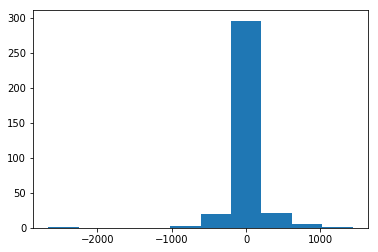

In [54]:
plt.hist(residual_6)
plt.show()

Quite normal looking

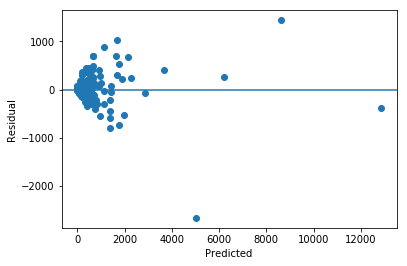

In [55]:
plt.scatter(predicted_6, residual_6)
plt.axhline(y=0)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.show()

The best model is probably either 2 or 6. Model 1 has a very high R-squared but is probably overfitting due to overly correlated data.